<a href="https://colab.research.google.com/github/kusanele/Customer-Sales/blob/main/transaction_types_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import datetime as dt

import xgboost as xgb
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score

import seaborn as sns
color_pal = sns.color_palette()
import plotly.express as px


import datetime


In [ ]:
sales_pred = pd.read_csv("d.csv")
sales_pred.head(1)

,Year,Quarter,Month,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number,Date
0,2019,Qtr 1,March,11,1481937.04,Invoice,3,2019/3/11


In [ ]:
#Covert TRANSACTION DATE to datetime data type
sales_pred['Date'] = pd.to_datetime(sales_pred['Date'])

In [ ]:
sales_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884 entries, 0 to 2883
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Year                        2884 non-null   int64         
 1   Quarter                     2884 non-null   object        
 2   Month                       2884 non-null   object        
 3   Day                         2884 non-null   int64         
 4   First HOME CURRENCY AMOUNT  2884 non-null   float64       
 5   TRANSACTION TYPE            2884 non-null   object        
 6   month_number                2884 non-null   int64         
 7   Date                        2884 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 180.4+ KB


# Data Pre-processing

Data encording is introduced because our ml model can not use categorical values to train our model.

In that case we will encode our data as below:

Invoice = 1

Receipt = 2

Credit Note = 3

In [ ]:
sales_pred.head(3)

,Year,Quarter,Month,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number,Date
0,2019,Qtr 1,March,11,1481937.04,Invoice,3,2019-03-11
1,2019,Qtr 1,March,14,228422.24,Invoice,3,2019-03-14
2,2019,Qtr 1,March,18,310000.00,Receipt,3,2019-03-18


In [ ]:
sales_pred["TRANSACTION TYPE"].unique()

array(['Invoice', 'Receipt', 'Credit Note'], dtype=object)

In [ ]:
# Replace multiple values
pr = sales_pred.replace(['Invoice', 'Receipt', 'Credit Note'],[1,2,3])
pr.tail(3)

,Year,Quarter,Month,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number,Date
2881,2023,Qtr 1,February,10,410057.29,1,2,2023-02-10
2882,2023,Qtr 1,February,10,3389846.97,2,2,2023-02-10
2883,2023,Qtr 4,December,31,1227447.87,2,12,2023-12-31


In [ ]:
pr =pr.drop(['Quarter', 'Month'], axis=1)

In [ ]:
pr.head(3)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number,Date
0,2019,11,1481937.04,1,3,2019-03-11
1,2019,14,228422.24,1,3,2019-03-14
2,2019,18,310000.00,2,3,2019-03-18


**Train Test Split**

***Train***

In [ ]:
train = pr.loc[pr["Date"] < '01-01-2022' ]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 2064
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Year                        2065 non-null   int64         
 1   Day                         2065 non-null   int64         
 2   First HOME CURRENCY AMOUNT  2065 non-null   float64       
 3   TRANSACTION TYPE            2065 non-null   int64         
 4   month_number                2065 non-null   int64         
 5   Date                        2065 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 112.9 KB


***Test***

In [ ]:
test = pr.loc[pr["Date"] > '01-01-2022' ]

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 2068 to 2883
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Year                        816 non-null    int64         
 1   Day                         816 non-null    int64         
 2   First HOME CURRENCY AMOUNT  816 non-null    float64       
 3   TRANSACTION TYPE            816 non-null    int64         
 4   month_number                816 non-null    int64         
 5   Date                        816 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 44.6 KB


In [ ]:
trs = train.set_index('Date')
trs.index = pd.to_datetime(trs.index)

In [ ]:
trs.head(1)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number
Date,,,,,
2019-03-11,2019,11,1481937.04,1,3


In [ ]:
tts = test.set_index('Date')
tts.index = pd.to_datetime(tts.index)

In [ ]:
tts.head(1)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number
Date,,,,,
2022-01-02,2022,2,224929.7,1,1


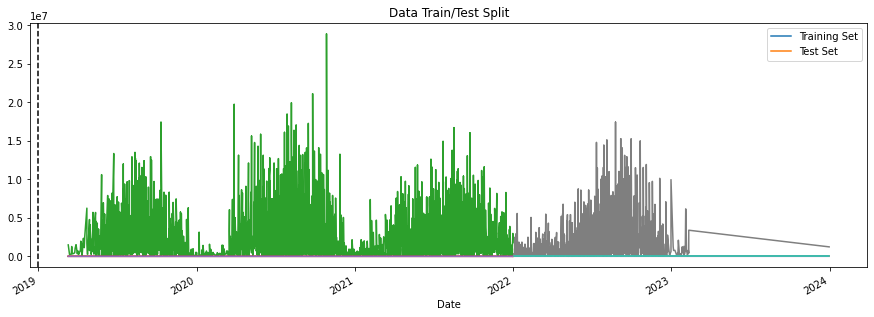

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
trs.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
tts.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
pr.head(1)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number,Date
0,2019,11,1481937.04,1,3,2019-03-11


In [ ]:
dfxplt = pr.set_index('Date')
dfxplt.index = pd.to_datetime(dfxplt.index)

In [ ]:
dfxplt.head(1)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number
Date,,,,,
2019-03-11,2019,11,1481937.04,1,3


In [ ]:
def create_features(dfxplt):
    """
    Create time series features based on time series index.
    """
    dfxplt = dfxplt.copy()
    dfxplt['hour'] = dfxplt.index.hour
    dfxplt['dayofweek'] = dfxplt.index.dayofweek
    dfxplt['quarter'] = dfxplt.index.quarter
    dfxplt['month'] = dfxplt.index.month
    dfxplt['year'] = dfxplt.index.year
    dfxplt['dayofyear'] = dfxplt.index.dayofyear
    dfxplt['dayofmonth'] = dfxplt.index.day
    dfxplt['weekofyear'] = dfxplt.index.isocalendar().week
    return dfxplt

dfplt = create_features(dfxplt)

**Visualize our Feature / Target Relationship**

In [ ]:
#Rename column
dfplt.rename(columns={'First HOME CURRENCY AMOUNT': 'HOME CURRENCY AMOUNT'}, inplace=True)
dfplt.head(1)

,Year,Day,HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,
2019-03-11,2019,11,1481937.04,1,3,0,0,1,3,2019,70,11,11


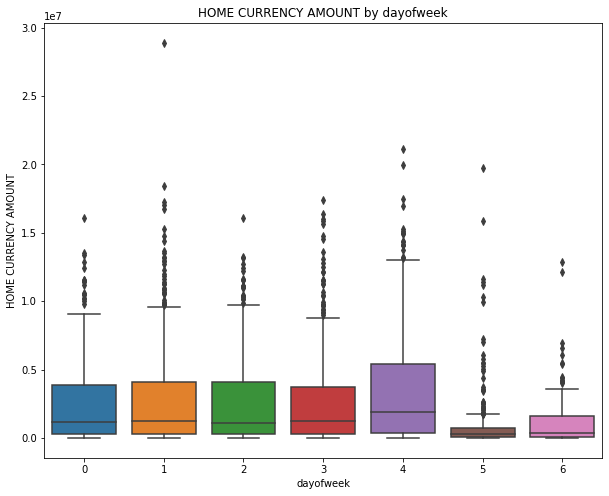

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=dfplt, x='dayofweek', y='HOME CURRENCY AMOUNT')
ax.set_title('HOME CURRENCY AMOUNT by dayofweek')
plt.show()

**Modeling**

In [ ]:
tts.head(1)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number
Date,,,,,
2022-01-02,2022,2,224929.7,1,1


In [ ]:
tts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 2022-01-02 to 2023-12-31
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        816 non-null    int64  
 1   Day                         816 non-null    int64  
 2   First HOME CURRENCY AMOUNT  816 non-null    float64
 3   TRANSACTION TYPE            816 non-null    int64  
 4   month_number                816 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 38.2 KB


In [ ]:
tts=tts.drop(["Year","Day", "month_number"], axis=1)

In [ ]:
#Rename column
tts.rename(columns={'First HOME CURRENCY AMOUNT': 'HOME CURRENCY AMOUNT'}, inplace=True)
tts.head(1)

,HOME CURRENCY AMOUNT,TRANSACTION TYPE
Date,,
2022-01-02,224929.7,1


In [ ]:
trs.head()

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number
Date,,,,,
2019-03-11,2019,11,1481937.04,1,3
2019-03-14,2019,14,228422.24,1,3
2019-03-18,2019,18,310000.00,2,3
2019-03-19,2019,19,1275404.00,1,3
2019-03-20,2019,20,313049.16,1,3


In [ ]:
trs.head(1)

,Year,Day,First HOME CURRENCY AMOUNT,TRANSACTION TYPE,month_number
Date,,,,,
2019-03-11,2019,11,1481937.04,1,3


In [ ]:
trs=trs.drop(["Year","Day", "month_number"], axis=1)

In [ ]:
#Rename column
trs.rename(columns={'First HOME CURRENCY AMOUNT': 'HOME CURRENCY AMOUNT'}, inplace=True)
trs.head(1)

,HOME CURRENCY AMOUNT,TRANSACTION TYPE
Date,,
2019-03-11,1481937.04,1


In [ ]:
tts.head(1)

,HOME CURRENCY AMOUNT,TRANSACTION TYPE
Date,,
2022-01-02,224929.7,1


In [ ]:
train = create_features(trs)
test = create_features(tts)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','TRANSACTION TYPE']
TARGET = 'HOME CURRENCY AMOUNT'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
X_train.head(1)

,dayofyear,dayofweek,quarter,month,year,TRANSACTION TYPE
Date,,,,,,
2019-03-11,70,0,1,3,2019,1


In [ ]:
X_test.head(1)

,dayofyear,dayofweek,quarter,month,year,TRANSACTION TYPE
Date,,,,,,
2022-01-02,2,6,1,1,2022,1


In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[06:44:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4396664.31302	validation_1-rmse:3597038.73509
[100]	validation_0-rmse:3068691.04241	validation_1-rmse:2442226.85031
[200]	validation_0-rmse:2705391.12817	validation_1-rmse:2183755.35009
[300]	validation_0-rmse:2590703.68930	validation_1-rmse:2149408.01056
[400]	validation_0-rmse:2521404.49320	validation_1-rmse:2123331.51446
[500]	validation_0-rmse:2477308.37888	validation_1-rmse:2106140.05116
[600]	validation_0-rmse:2443954.71050	validation_1-rmse:2092480.77651
[700]	validation_0-rmse:2415271.20140	validation_1-rmse:2081275.18531
[800]	validation_0-rmse:2390724.49031	validation_1-rmse:2071832.77521
[900]	validation_0-rmse:2371581.56239	validation_1-rmse:2066619.86006
[999]	validation_0-rmse:2352209.96982	validation_1-rmse:2061426.93334


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

**Feature Importance**

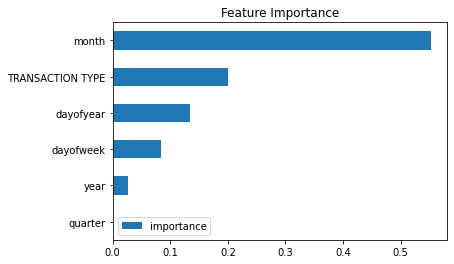

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

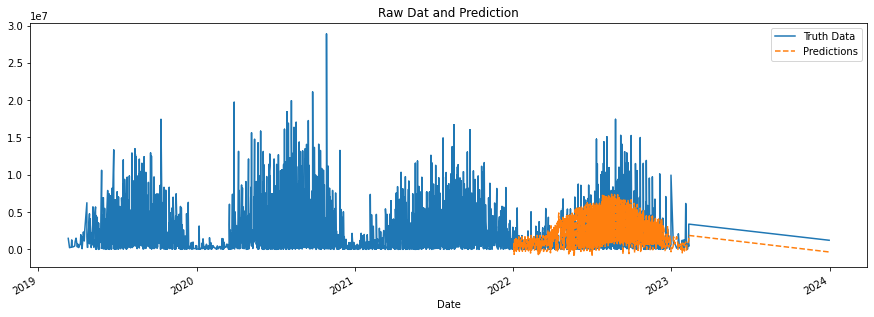

In [ ]:
test['prediction'] = reg.predict(X_test)
dfplt = dfplt.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = dfplt[['HOME CURRENCY AMOUNT']].plot(figsize=(15, 5))
dfplt['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


**Score (RMSE)**

In [ ]:
rmse_score = np.sqrt(mean_squared_error(test['HOME CURRENCY AMOUNT'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')

RMSE Score on Test set: 2061351.02


**Error**

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-02-03    5.159760e+06
2022-08-09    5.075483e+06
2022-06-16    4.612174e+06
2022-08-25    4.502403e+06
2022-12-31    4.099556e+06
2022-09-30    4.008189e+06
2022-06-07    3.952494e+06
2022-09-15    3.883977e+06
2022-04-27    3.876303e+06
2022-10-21    3.816289e+06
Name: error, dtype: float64

**Predict home currency sales for the next 18 Months**

In [ ]:
s_pred = pd.read_csv("test_fin.csv")
s_pred['TRANSACTION DATE']

0     2023/03/06
1     2023/03/06
2     2023/03/06
3     2023/03/07
4     2023/03/07
5     2023/03/07
6     2023/03/08
7     2023/03/08
8     2023/03/08
9     2023/03/09
10    2023/03/09
11    2023/03/09
12    2023/03/10
13    2023/03/10
14    2023/03/10
15    2023/03/11
16    2023/03/11
17    2023/03/11
18    2023/03/12
19    2023/03/12
20    2023/03/12
21    2023/03/13
22    2023/03/13
23    2023/03/13
Name: TRANSACTION DATE, dtype: object

In [ ]:
t_date = s_pred['TRANSACTION DATE']

In [ ]:
s_pred.rename(columns={'T_type': 'TRANSACTION TYPE'}, inplace=True)


In [ ]:
s_pred.head(1)

,dayofyear,dayofweek,quarter,month,year,TRANSACTION TYPE,TRANSACTION DATE
0,65,1,1,3,2023,1,2023/03/06


In [ ]:
test_data_set = s_pred[['dayofyear','dayofweek','quarter','month', 'year',	'TRANSACTION TYPE']].copy()

In [ ]:
test_data_set

,dayofyear,dayofweek,quarter,month,year,TRANSACTION TYPE
0,65,1,1,3,2023,1
1,65,1,1,3,2023,2
2,65,1,1,3,2023,3
3,66,2,1,3,2023,1
4,66,2,1,3,2023,2
5,66,2,1,3,2023,3
6,67,3,1,3,2023,1
7,67,3,1,3,2023,2
8,67,3,1,3,2023,3
9,68,4,1,3,2023,1


In [ ]:
# use the model to predict sales for the next 18 months
y_pred = reg.predict(test_data_set)

In [ ]:
# create a dataframe with the predicted sales for the next 18 months
y_pred

array([1413736.1  ,  842144.06 , -238778.73 ,  927277.9  ,  530749.6  ,
       -550173.75 ,  990998.7  ,  594470.44 , -486452.72 , 1137956.8  ,
       1874448.9  ,  496471.75 ,  645108.7  , -195914.58 ,   76645.516,
        560998.5  , -288214.3  ,   98575.94 , 1029519.06 ,  274965.78 ,
       -621209.5  , 1564275.5  ,  949763.75 , -173479.56 ], dtype=float32)

In [ ]:
test_data_set['Predicted_Income'] = y_pred.tolist()

In [ ]:
zero = test_data_set['Predicted_Income'].where(test_data_set['Predicted_Income'] > 1 , 0)

In [ ]:
zero.head(1)

0    1413736.125
Name: Predicted_Income, dtype: float64

In [ ]:
test_data_set.index = zero.index
# Assign the columns.
test_data_set['Predicted_Income'] = zero


In [ ]:
test_data_set.index = t_date.index
test_data_set['Date']= t_date

In [ ]:
test_data_set.head(1)

,dayofyear,dayofweek,quarter,month,year,TRANSACTION TYPE,Predicted_Income,Date
0,65,1,1,3,2023,1,1413736.125,2023/03/06


Invoice = 1

Receipt = 2

Credit Note = 3

In [ ]:
# Using DataFrame.insert() to add a column
test_data_set.insert(6, "TRANSACTION TYPE NAME", ['Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note','Invoice','Receipt', 'Credit Note'], True)

In [ ]:
test_data_set

,dayofyear,dayofweek,quarter,month,year,TRANSACTION TYPE,TRANSACTION TYPE NAME,Predicted_Income,Date
0,65,1,1,3,2023,1,Invoice,1.413736e+06,2023/03/06
1,65,1,1,3,2023,2,Receipt,8.421441e+05,2023/03/06
2,65,1,1,3,2023,3,Credit Note,0.000000e+00,2023/03/06
3,66,2,1,3,2023,1,Invoice,9.272779e+05,2023/03/07
4,66,2,1,3,2023,2,Receipt,5.307496e+05,2023/03/07
5,66,2,1,3,2023,3,Credit Note,0.000000e+00,2023/03/07
6,67,3,1,3,2023,1,Invoice,9.909987e+05,2023/03/08
7,67,3,1,3,2023,2,Receipt,5.944704e+05,2023/03/08
8,67,3,1,3,2023,3,Credit Note,0.000000e+00,2023/03/08
9,68,4,1,3,2023,1,Invoice,1.137957e+06,2023/03/09


In [ ]:
test_data_set.to_csv('trans_type_ml_Prediction')